# 1. Bibliotecas

In [2]:
# 1. Bibliotecas
import math
import numpy as np
import pandas as pd
import random as rd
from scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn import metrics
import folium

# 2. Lendo os Datasets

In [3]:
df_bts = pd.read_csv('../../project_files/03_processed_files/bts.csv', delimiter=',', encoding='utf-8', index_col=False)
df_train = pd.read_csv('../../project_files/03_processed_files/meds_train_alunos.csv', delimiter=',', encoding='utf-8', index_col=False)

## 2.1 alterando os datasets

In [4]:
# dropando colunas que não serão usadas
df_bts = df_bts.iloc[:, 2:].drop(columns=['id_bts', 'nom_bts', 'nom_canal_controle_bts'])
df_train = df_train.iloc[:,2:]
# adicionando uma coluna para as distancias reais que serão preditas
df_train['rd_1'] = 0.0 # distância real para as bts de setor 1
df_train['rd_2'] = 0.0 # distância real para as bts de setor 2
df_train['rd_3'] = 0.0 # distância real para as bts de setor 3

In [5]:
def ED(lat1 : float, lon1 : float, lat2 : float, lon2 : float): #  coordenadas dos pontos e das torres
  """Calcula a distância em quilômetros entre as coordenadas de um dos pontos e uma das torres
  usando a distância haversine"""
  earth_radius = 6371.0 * 1000

  # Converte latitude e longitude de graus para radianos
  lat1_rad = math.radians(lat1)
  lon1_rad = math.radians(lon1)
  lat2_rad = math.radians(lat2)
  lon2_rad = math.radians(lon2)

  # Fórmula Haversine
  dlat = lat2_rad - lat1_rad
  dlon = lon2_rad - lon1_rad
  a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
  c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

  # Calcula a distância
  distance = earth_radius * c

  return distance

In [6]:
for i in range(df_train.shape[0]):
  df_train.loc[i, 'rd_1'] = ED(df_train.loc[i, 'num_lat_bts'], df_train.loc[i, 'num_long_bts'], df_bts.loc[0, 'num_lat_bts'], df_bts.loc[0, 'num_long_bts']) 
  df_train.loc[i, 'rd_2'] = ED(df_train.loc[i, 'num_lat_bts'], df_train.loc[i, 'num_long_bts'], df_bts.loc[3, 'num_lat_bts'], df_bts.loc[3, 'num_long_bts'])
  df_train.loc[i, 'rd_3'] = ED(df_train.loc[i, 'num_lat_bts'], df_train.loc[i, 'num_long_bts'], df_bts.loc[6, 'num_lat_bts'], df_bts.loc[6, 'num_long_bts'])

In [7]:
df_train

id_ponto    rssi_1_1    rssi_1_2    rssi_1_3    rssi_2_1    rssi_2_2  \
0         6604 -103.705000 -110.425000 -107.381667 -110.330000 -108.345000   
1         5515 -105.225000 -115.000000 -105.210000 -115.000000 -105.835000   
2         5049 -102.610000 -115.000000 -101.380000 -115.000000 -104.295000   
3         8737  -89.140000  -97.251429  -86.642857  -96.036667  -96.592500   
4         1203 -109.088333 -107.200000 -107.010000 -108.430000 -104.845714   
...        ...         ...         ...         ...         ...         ...   
6758      5734 -105.225000 -115.000000 -105.210000 -115.000000 -105.835000   
6759      5191 -105.225000 -115.000000 -105.210000 -115.000000 -105.835000   
6760      5390 -105.225000 -115.000000 -105.210000 -115.000000 -105.835000   
6761       860 -109.088333 -107.200000 -107.010000 -108.430000  -97.200000   
6762      7270  -89.254286  -91.887143  -89.297143  -85.120000  -83.190000   

        rssi_2_3    rssi_3_1    rssi_3_2  rssi_3_3  delay_1  delay_2  delay_3  \
0    -106.590000 -107.153333 -102.120000 -115.0000      5.0      3.0      2.0   
1    -115.000000  -88.470000  -94.024286 -108.1200      5.0      3.0      2.0   
2     -97.360000  -96.980000  -99.572500 -115.0000      5.0      3.0      2.0   
3     -92.460000  -86.813333 -102.688000  -87.2700      4.0      7.0      2.0   
4    -101.435714 -103.065000 -102.110000 -115.0000      5.0      3.0      2.0   
...          ...         ...         ...       ...      ...      ...      ...   
6758 -115.000000  -93.005000  -97.114286 -108.1200      5.0      3.0      2.0   
6759 -115.000000  -87.315000  -88.735714 -108.1200      5.0      3.0      2.0   
6760 -115.000000  -95.165000  -90.705714 -108.1200      5.0      3.0      2.0   
6761  -98.148571  -99.840000  -94.665000 -115.0000      5.0      3.0      2.0   
6762  -84.626190  -91.120000 -101.740000  -96.3725      5.0      3.0      3.0   

      num_lat_bts  num_long_bts  flag_indoor         rd_1         rd_2  \
0       -8.055786    -34.951505            1  1376.116069   818.323014   
1       -8.055784    -34.951608            1  1375.491341   828.673816   
2       -8.055506    -34.951693            1  1344.326875   825.918687   
3       -8.050390    -34.959630            0  1142.968177  1670.154895   
4       -8.055380    -34.951736            1  1330.208922   825.547524   
...           ...           ...          ...          ...          ...   
6758    -8.055784    -34.951608            1  1375.491341   828.673816   
6759    -8.055784    -34.951608            1  1375.491341   828.673816   
6760    -8.055784    -34.951608            1  1375.491341   828.673816   
6761    -8.055380    -34.951736            1  1330.208922   825.547524   
6762    -8.055320    -34.951080            0  1327.090856   755.481733   

            rd_3  
0     705.979147  
1     694.653615  
2     683.689740  
3     580.338100  
4     678.675535  
...          ...  
6758  694.653615  
6759  694.653615  
6760  694.653615  
6761  678.675535  
6762  750.866943  

[6763 rows x 19 columns]

In [8]:
## 2.2 Separando os dados para submeter arquivo
ind_rem = rd.sample(range(df_train.shape[0]), int(df_train.shape[0] * 0.1))
rem_df = pd.DataFrame(columns=df_train.columns)
rem_data, init_data = [], []

In [9]:
for i in range(df_train.shape[0]):
  data = dict()
  for c,v in zip(list(df_train.columns), df_train.loc[i,:]):
    data[c] = v
  if df_train.loc[i, 'id_ponto'] in ind_rem:
    rem_data.append(data)
  else:
    init_data.append(data)

In [10]:
df_train = pd.DataFrame(columns=df_train.columns, data=init_data)
rem_df = pd.DataFrame(columns=df_train.columns, data=rem_data)

# 3. Separando os Dados

In [11]:
X = df_train.drop(columns=['id_ponto','num_lat_bts', 'num_long_bts', 'rd_1', 'rd_2', 'rd_3'])
X_columns = X.columns
tv = [] # train vector composed of X_train, X_test, y_train, y_test for each bts cluster
for i in range(3):
  X_train, X_test, y_train, y_test = train_test_split(X.values, df_train.iloc[:, 16 + i], test_size=0.25, random_state=13)
  tv.append((X_train, X_test, y_train, y_test))

# 4. Funções Auxiliares

In [12]:
def lat_lon_to_rectangular(lat, lon):
    # Radius of the Earth (mean value) in meters
    earth_radius = 6371000.0
    
    # Convert latitude and longitude from degrees to radians
    lat_rad = math.radians(lat)
    lon_rad = math.radians(lon)
    
    # Calculate x and y coordinates using Mercator projection
    x = earth_radius * lon_rad
    y = earth_radius * math.log(math.tan(math.pi / 4 + lat_rad / 2))
    
    return x, y
def rectangular_to_lat_lon(x, y):
    # Radius of the Earth (mean value) in meters
    earth_radius = 6371000.0
    
    # Calculate latitude
    lat_rad = math.atan(math.exp(y / earth_radius))
    latitude = math.degrees(2 * lat_rad - math.pi / 2)
    
    # Calculate longitude
    longitude = math.degrees(x / earth_radius)
    
    return latitude, longitude

def calculate_coordinates(bts, dists):
  def optf(args, bts, dists): # optimize function
    soma = 0
    r, theta = args
    for i in range(len(bts)):
      xi,yi, _ = bts[i]
      d = dists[i]
      soma += abs(d - math.sqrt((r * math.cos(theta) - xi)**2 + ((r * math.sin(theta) - yi)**2)))
    return -soma
  
  # define constraints
  r_min, r_max = bts[0][2] * 234, (bts[0][2]+1) * 234
  
  # define constraints for r
  constraints = (
    {'type': 'ineq', 'fun': lambda params: params[0] - r_min},  # r >= r_min
    {'type': 'ineq', 'fun': lambda params: r_max - params[0]},  # r <= r_max
  )

  # Define initial guess for r and beta
  initial_guess = [1.0, 0.0]
  # Call the minimize function
  result = minimize(optf, initial_guess, args=(bts, dists), constraints=constraints, method='SLSQP')
  # Extract the optimized values of r and beta
  optimized_r, optimized_beta = result.x
  return optimized_r, optimized_beta

In [13]:
bts_cords = [
  [*lat_lon_to_rectangular(df_bts.loc[0, 'num_lat_bts'], df_bts.loc[0, 'num_long_bts']), 0.0],
  [*lat_lon_to_rectangular(df_bts.loc[3, 'num_lat_bts'],df_bts.loc[3, 'num_long_bts']), 0.0],
  [*lat_lon_to_rectangular(df_bts.loc[6, 'num_lat_bts'],df_bts.loc[6, 'num_long_bts']), 0.0]
]

In [14]:
bts_cords

[[-3886485.0760806166, -897339.7762058176, 0.0],
 [-3885670.2396581653, -898403.2667475431, 0.0],
 [-3887141.12614782, -898676.1622042521, 0.0]]

# 5. Treinando o Modelo

In [15]:
modelos = []
for X_train, X_test, y_train, y_test in tv:
    t = RandomForestRegressor(max_depth=15).fit(X_train, y_train)
    modelos.append(t)
    # yhat = t.predict(X_test)
    # print(metrics.mean_squared_error(y_test, yhat))

# 6. Computando as localizações

In [16]:
submit_df = pd.DataFrame(columns= ['ex_lat, ex_lon, pred_lat, pred_lon']) # datafram pra armazena os valores originais e os preditos
result_data = []

In [17]:
def main():
  result_data = []
  for i in range(2):
    row_train_values = np.array(df_train.loc[i, X_columns]).reshape(1,-1)
    # print(row_train_values)
    pred1, pred2, pred3 = modelos[0].predict(row_train_values), modelos[1].predict(row_train_values), modelos[2].predict(row_train_values)
    bts_cords[0][2] = df_train.loc[i, 'delay_1']
    best_r, best_angle = calculate_coordinates(bts_cords, [pred1, pred2, pred3])
    print(best_r, best_angle)
    pred_x, pred_y = bts_cords[0][0] + best_r * math.sin(best_angle), bts_cords[0][1] + best_r * math.cos(best_angle)
    pred_lat, pred_lon = rectangular_to_lat_lon(pred_x, pred_y)
    result_data.append({
      'ex_lat' : df_train.loc[i, 'num_lat_bts'],
      'ex_lon' : df_train.loc[i, 'num_long_bts'],
      'pred_lat' : pred_lat,
      'pred_lon' : pred_lon
    })

In [18]:
main()

1404.0000000009147 0.22711553615711758
1404.0000000000528 0.22710718839302887


In [19]:
result_data

[]

# 7. Criando o submit_alunos

In [20]:
error_data = []
result_data = []
comp_data = []

In [21]:
def main():
  for i in range(rem_df.shape[0]):
    row_train_values = np.array(rem_df.loc[i, X_columns]).reshape(1,-1)
    # print(row_train_values)
    pred1, pred2, pred3 = modelos[0].predict(row_train_values), modelos[1].predict(row_train_values), modelos[2].predict(row_train_values)
    bts_cords[0][2] = rem_df.loc[i, 'delay_1']
    best_r, best_angle = calculate_coordinates(bts_cords, [pred1, pred2, pred3])
    # print(best_r, best_angle)
    pred_x, pred_y = bts_cords[0][0] + best_r * math.sin(best_angle), bts_cords[0][1] + best_r * math.cos(best_angle)
    pred_lat, pred_lon = rectangular_to_lat_lon(pred_x, pred_y)
    result_data.append({
      'ponto_id' : rem_df.loc[i, 'id_ponto'],
      'lat' : pred_lat,
      'lon' : pred_lon
    })
    error_data.append({
      'ponto_id' : rem_df.loc[i, 'id_ponto'],
      'erro(metros)' : ED(pred_lat, pred_lon, rem_df.loc[i, 'num_lat_bts'], rem_df.loc[i, 'num_long_bts'])
    })
    comp_data.append({
      'ponto_id' : rem_df.loc[i, 'id_ponto'],
      'pred_lat' : pred_lat,
      'pred_lon' : pred_lon,
      'orig_lat' : rem_df.loc[i, 'num_lat_bts'],
      'orig_lon': rem_df.loc[i, 'num_long_bts']
    })

In [22]:
error_data = []
result_data = []
comp_data = []
main()

In [23]:
result_data

[{'ponto_id': 2626.0, 'lat': -8.031238592366611, 'lon': -34.94915702356696},
 {'ponto_id': 3519.0, 'lat': -8.031238594931716, 'lon': -34.94915701235717},
 {'ponto_id': 4607.0, 'lat': -8.031238596738348, 'lon': -34.94915700446209},
 {'ponto_id': 585.0, 'lat': -8.031238586033147, 'lon': -34.94915705124499},
 {'ponto_id': 5905.0, 'lat': -8.03123861586675, 'lon': -34.94915692087077},
 {'ponto_id': 6429.0, 'lat': -8.03123861586675, 'lon': -34.94915692087077},
 {'ponto_id': 4665.0, 'lat': -8.031238596738348, 'lon': -34.94915700446209},
 {'ponto_id': 865.0, 'lat': -8.031238608277107, 'lon': -34.94915695403732},
 {'ponto_id': 4024.0, 'lat': -8.031238649125163, 'lon': -34.94915677553747},
 {'ponto_id': 1487.0, 'lat': -8.031238608277107, 'lon': -34.94915695403732},
 {'ponto_id': 4938.0, 'lat': -8.031238596738348, 'lon': -34.94915700446209},
 {'ponto_id': 549.0, 'lat': -8.031238586033147, 'lon': -34.94915705124499},
 {'ponto_id': 2549.0, 'lat': -8.031238592366611, 'lon': -34.94915702356696},
 {'p

In [24]:
submit_df = pd.DataFrame(columns=['ponto_id', 'lat', 'lon'], data=result_data)
submit_df

ponto_id       lat        lon
0      2626.0 -8.031239 -34.949157
1      3519.0 -8.031239 -34.949157
2      4607.0 -8.031239 -34.949157
3       585.0 -8.031239 -34.949157
4      5905.0 -8.031239 -34.949157
..        ...       ...        ...
474     502.0 -8.031239 -34.949157
475    3073.0 -8.031239 -34.949157
476    1585.0 -8.031239 -34.949157
477    2558.0 -8.031239 -34.949157
478    4426.0 -8.031239 -34.949157

[479 rows x 3 columns]

In [25]:
submit_df.to_csv('../../project_files/output/submit_alunos_trilateracao.csv', sep=';')

# 8. Gráficos do train

In [26]:
df_diff = pd.DataFrame(columns=['ponto_id', 'erro(metros)'], data=error_data)

In [27]:
df_diff.describe()

ponto_id  erro(metros)
count   479.000000    479.000000
mean   3354.981211   2733.185795
std    1961.579213     92.573465
min       2.000000   2699.376910
25%    1576.500000   2707.530111
50%    3411.000000   2724.167902
75%    5063.500000   2741.760242
max    6741.000000   3578.041116

<Axes: >

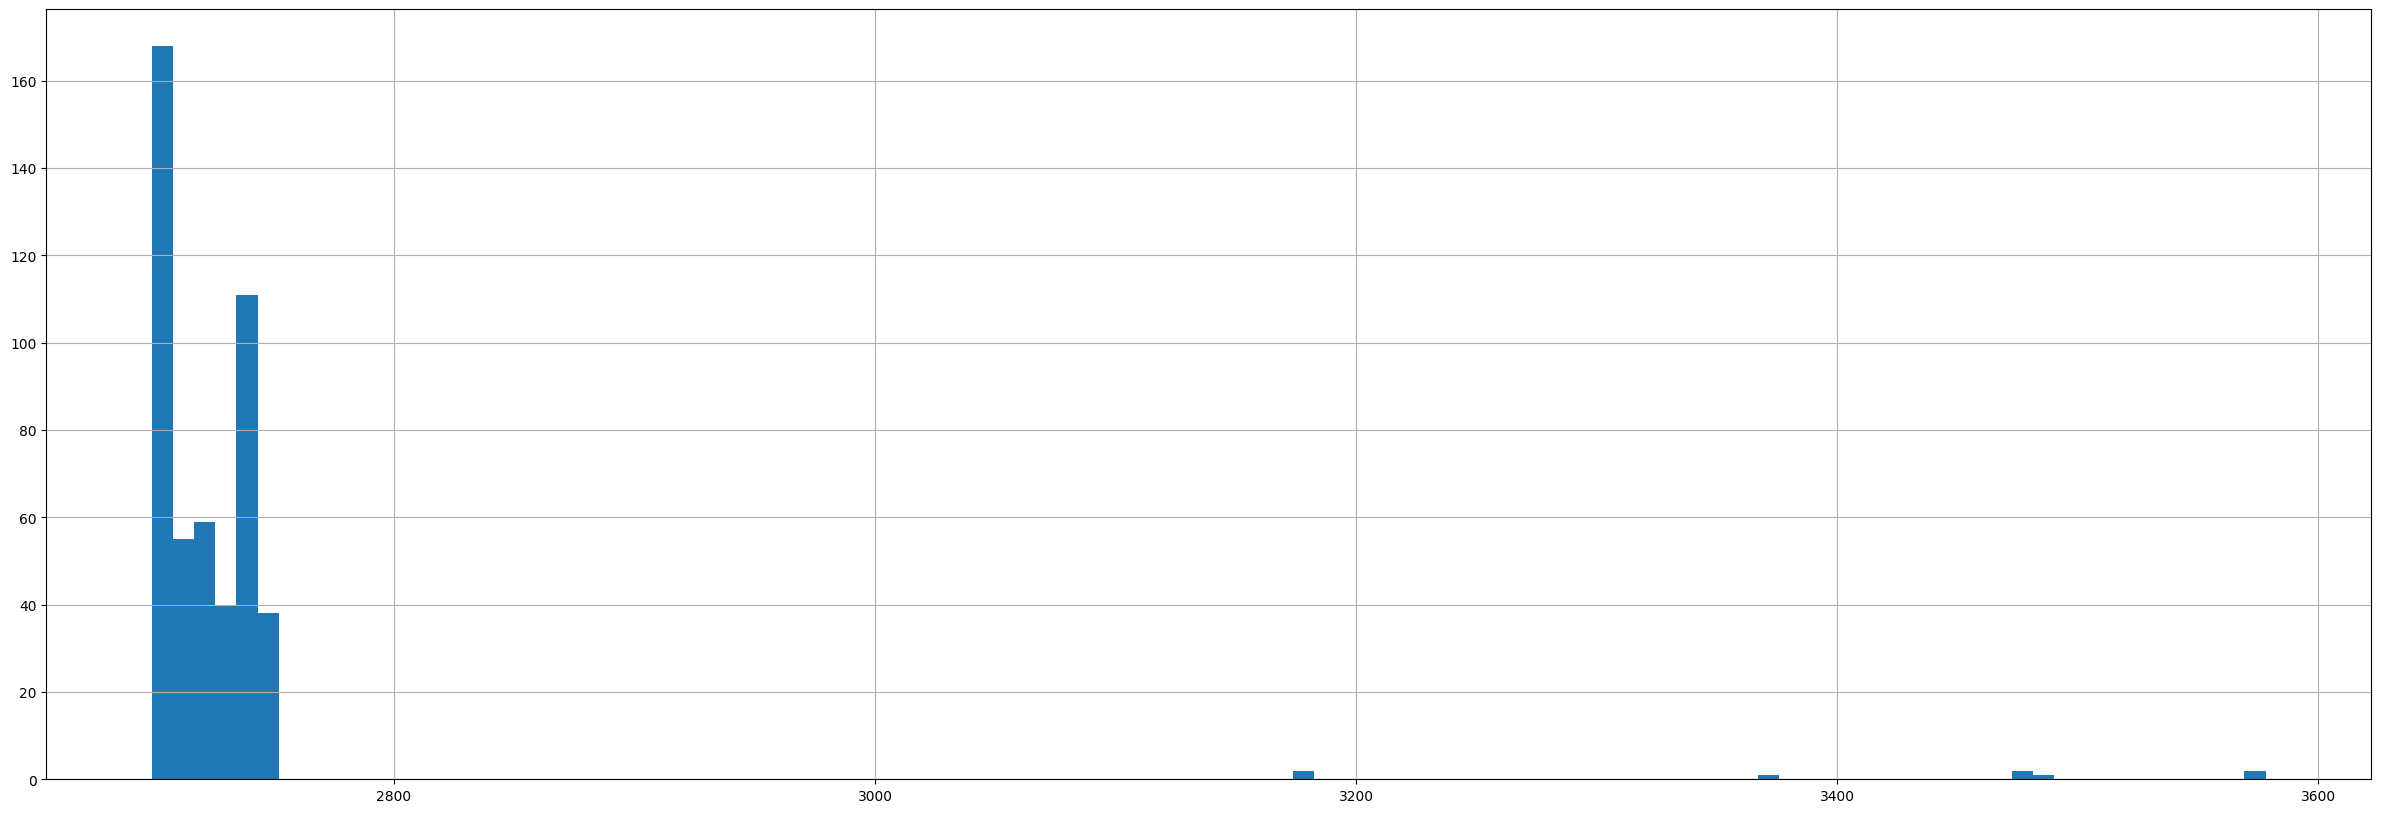

In [28]:
# histograma
df_diff['erro(metros)'].hist(bins=100,figsize=(30,10))

<Axes: >

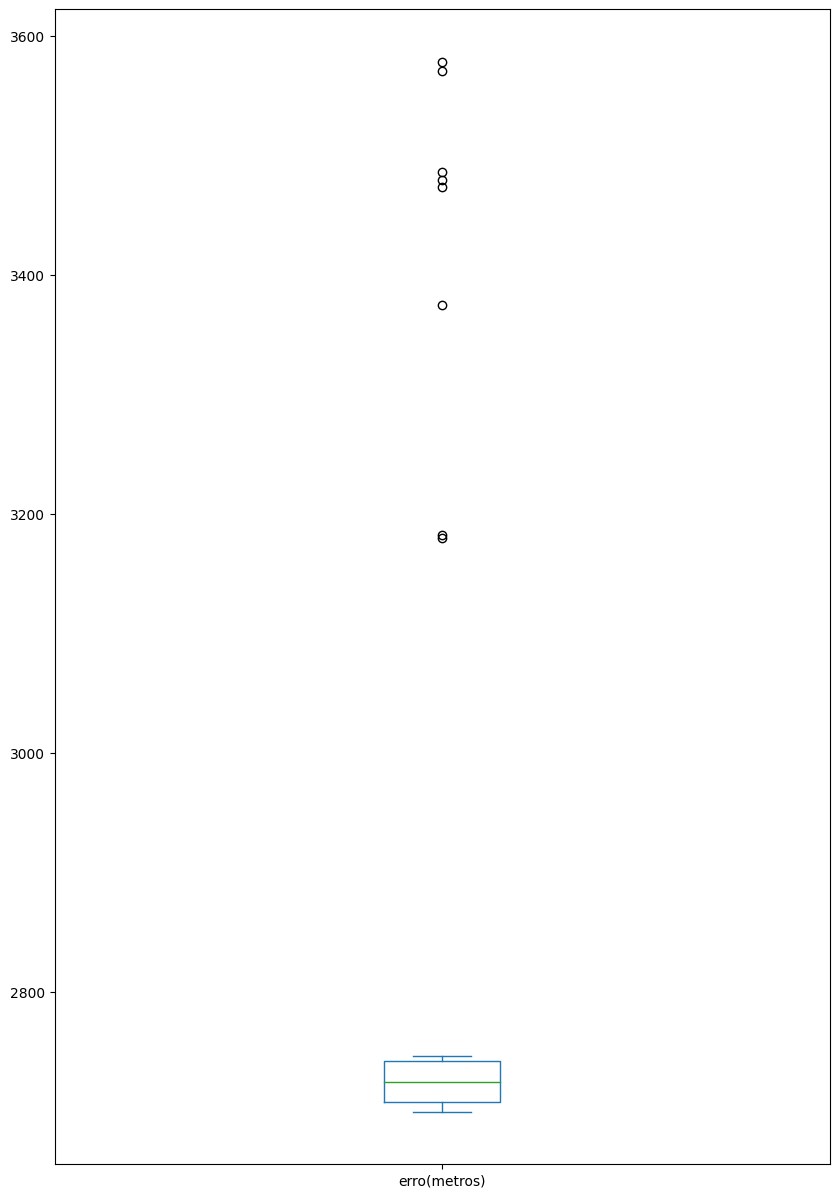

In [29]:
# boxplot
df_diff['erro(metros)'].plot(kind='box',figsize=(10,15))

In [30]:
comp_df = pd.DataFrame(columns=comp_data[0].keys(), data=comp_data)
comp_df

ponto_id  pred_lat   pred_lon  orig_lat   orig_lon
0      2626.0 -8.031239 -34.949157 -8.055684 -34.951331
1      3519.0 -8.031239 -34.949157 -8.055834 -34.951362
2      4607.0 -8.031239 -34.949157 -8.055506 -34.951693
3       585.0 -8.031239 -34.949157 -8.055605 -34.951728
4      5905.0 -8.031239 -34.949157 -8.055786 -34.951505
..        ...       ...        ...       ...        ...
474     502.0 -8.031239 -34.949157 -8.055605 -34.951728
475    3073.0 -8.031239 -34.949157 -8.055834 -34.951362
476    1585.0 -8.031239 -34.949157 -8.055380 -34.951736
477    2558.0 -8.031239 -34.949157 -8.055684 -34.951331
478    4426.0 -8.031239 -34.949157 -8.055506 -34.951693

[479 rows x 5 columns]

/tmp/ipykernel_278356/4042514183.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


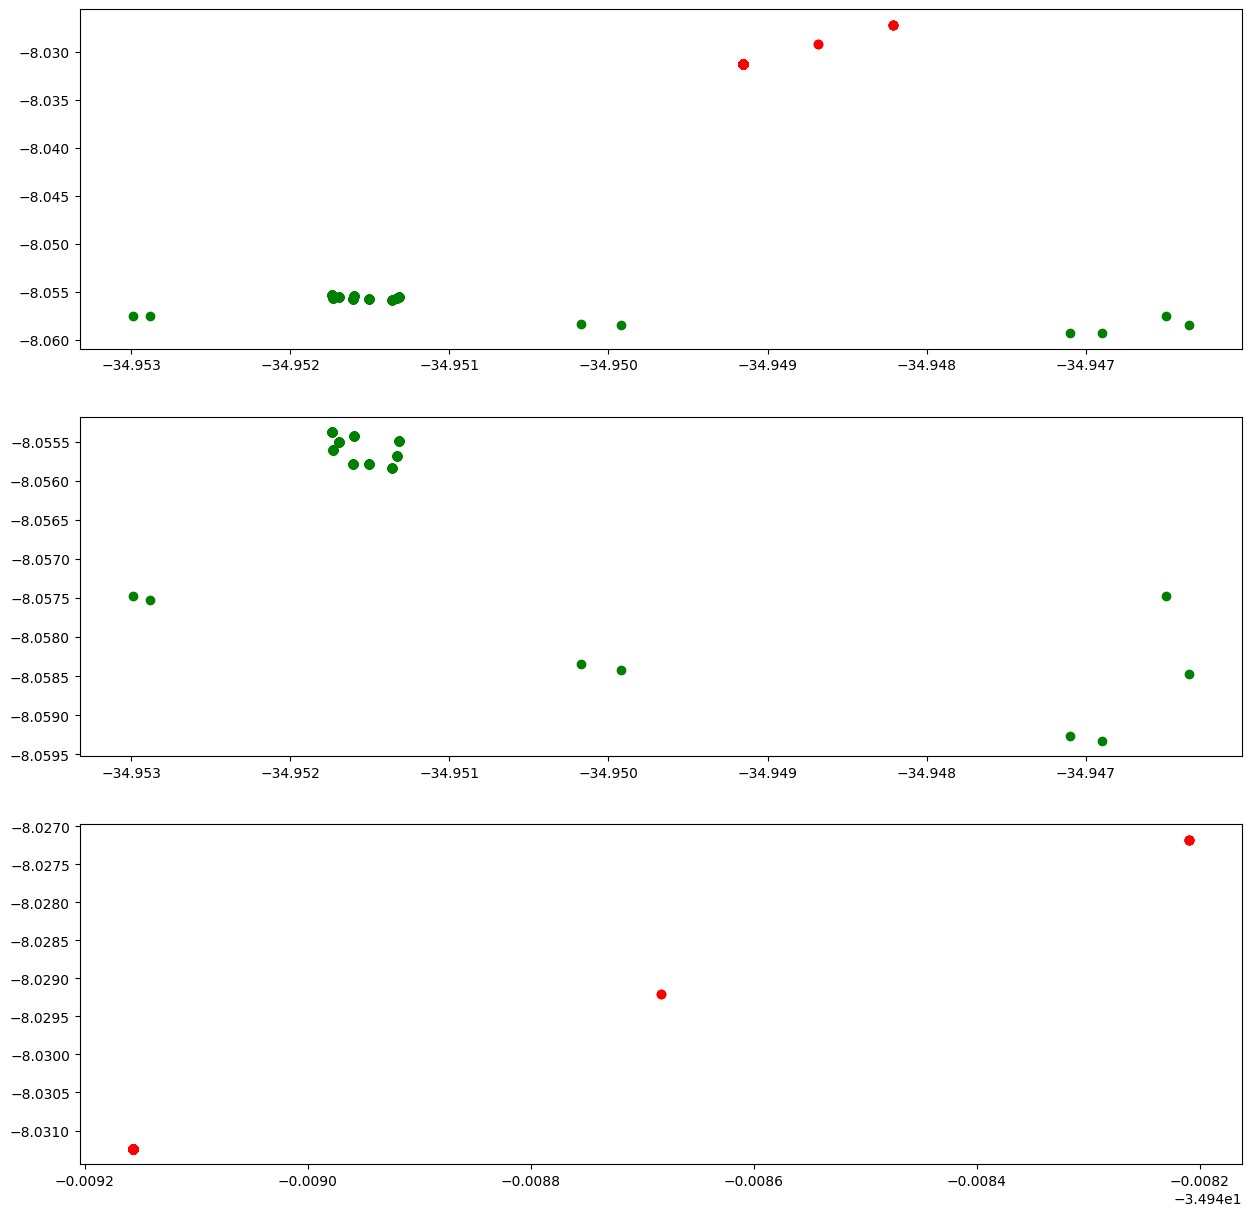

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(15,15))
ax1.scatter(comp_df['orig_lon'],comp_df['orig_lat'], c='green')
ax1.scatter(comp_df['pred_lon'],comp_df['pred_lat'], c='red')
#ax1.title('Mapa de comparação:')
#ax1.legend(["reais","preditas"])

ax2.scatter(comp_df['orig_lon'],comp_df['orig_lat'], c='green')
#ax2.title('Reais:')

ax3.scatter(comp_df['pred_lon'],comp_df['pred_lat'], c='red')
#ax3.title('Preditas')


fig.show()

# 8. Testing the test file

In [32]:
# training a model to predict if indoor or not
X = df_train.drop(columns=['id_ponto','num_lat_bts', 'num_long_bts', 'rd_1', 'rd_2', 'rd_3', 'flag_indoor'])
X_columns = X.columns
X_train, X_test, y_train, y_test = train_test_split(X.values, df_train['flag_indoor'], test_size=0.25, random_state=13)
model = RandomForestClassifier(max_depth=15).fit(X_train, y_train)
yhat = model.predict(X_test)
print(f'acc: {metrics.accuracy_score(y_test, yhat)}')

acc: 1.0


In [33]:
df_test = pd.read_csv('../../project_files/03_processed_files/meds_test_alunos.csv', sep=',')
df_test = df_test.loc[:, 'id_ponto':]

In [34]:
X_columns = df_test.drop(columns=['id_ponto','num_lat_bts', 'num_long_bts']).columns

In [35]:
df_test

id_ponto    rssi_1_1    rssi_1_2    rssi_1_3    rssi_2_1    rssi_2_2  \
0            0 -103.705000 -110.425000 -107.381667 -110.330000 -108.345000   
1            3 -105.225000 -115.000000 -105.210000 -115.000000 -105.835000   
2            8 -102.610000 -115.000000 -101.380000 -115.000000 -104.295000   
3           10  -89.140000  -97.251429  -86.642857  -96.036667  -96.592500   
4           12 -109.088333 -107.200000 -107.010000 -108.430000 -104.845714   
...        ...         ...         ...         ...         ...         ...   
2894      9672 -106.070000 -115.000000 -106.670000 -104.161667  -97.531429   
2895      9674 -100.830000 -115.000000  -98.560000 -115.000000 -100.406667   
2896      9675 -101.196667 -115.000000  -96.040000 -115.000000  -96.790000   
2897      9677 -109.088333 -107.200000 -107.010000 -108.430000  -98.651429   
2898      9678 -115.000000 -115.000000 -115.000000 -115.000000  -96.330000   

        rssi_2_3    rssi_3_1    rssi_3_2  rssi_3_3  delay_1  delay_2  delay_3  \
0    -106.590000 -107.153333 -102.120000   -115.00      5.0      3.0      2.0   
1    -115.000000  -88.470000  -94.024286   -108.12      5.0      3.0      2.0   
2     -97.360000  -96.980000  -99.572500   -115.00      5.0      3.0      2.0   
3     -92.460000  -86.813333 -102.688000    -87.27      5.0      3.0      2.0   
4    -101.435714 -103.065000 -102.110000   -115.00      5.0      3.0      2.0   
...          ...         ...         ...       ...      ...      ...      ...   
2894  -93.390000  -96.125714  -96.436667   -115.00      1.0      4.0      4.0   
2895  -97.845714  -99.255000  -98.118000   -115.00      1.0      4.0      4.0   
2896  -96.100000  -94.420000  -93.024000   -115.00      1.0      4.0      4.0   
2897 -100.040000 -101.130000  -96.545000   -115.00      1.0      4.0      5.0   
2898  -92.668333  -88.890000  -78.261429   -115.00      1.0      4.0      5.0   

      num_lat_bts  num_long_bts  
0       -8.055786    -34.951505  
1       -8.055784    -34.951608  
2       -8.055506    -34.951693  
3       -8.050390    -34.959630  
4       -8.055380    -34.951736  
...           ...           ...  
2894    -8.055424    -34.951597  
2895    -8.055834    -34.951362  
2896    -8.055506    -34.951693  
2897    -8.055380    -34.951736  
2898    -8.055684    -34.951331  

[2899 rows x 15 columns]

In [36]:
predict_indoor = model.predict(df_test.loc[:,'rssi_1_1':'delay_3'].values)
predict_indoor

array([1., 1., 1., ..., 1., 1., 1.])

In [37]:
df_test['flag_indoor'] = predict_indoor

In [38]:
X_columns = df_test.drop(columns=['id_ponto','num_lat_bts', 'num_long_bts']).columns

In [39]:
X_columns

Index(['rssi_1_1', 'rssi_1_2', 'rssi_1_3', 'rssi_2_1', 'rssi_2_2', 'rssi_2_3',
       'rssi_3_1', 'rssi_3_2', 'rssi_3_3', 'delay_1', 'delay_2', 'delay_3',
       'flag_indoor'],
      dtype='object')

In [40]:
def main():
  for i in range(df_test.shape[0]):
    row_train_values = df_test.loc[i, X_columns].values.reshape(1,-1)
    # print(row_train_values)
    pred1, pred2, pred3 = modelos[0].predict(row_train_values), modelos[1].predict(row_train_values), modelos[2].predict(row_train_values)
    bts_cords[0][2] = df_test.loc[i, 'delay_1']
    best_r, best_angle = calculate_coordinates(bts_cords, [pred1, pred2, pred3])
    # print(best_r, best_angle)
    pred_x, pred_y = bts_cords[0][0] + best_r * math.sin(best_angle), bts_cords[0][1] + best_r * math.cos(best_angle)
    pred_lat, pred_lon = rectangular_to_lat_lon(pred_x, pred_y)
    result_data.append({
      'ponto_id' : df_test.loc[i, 'id_ponto'],
      'lat' : pred_lat,
      'lon' : pred_lon
    })
    error_data.append({
      'ponto_id' : df_test.loc[i, 'id_ponto'],
      'erro(metros)' : ED(pred_lat, pred_lon, df_test.loc[i, 'num_lat_bts'], df_test.loc[i, 'num_long_bts'])
    })
    comp_data.append({
      'ponto_id' : df_test.loc[i, 'id_ponto'],
      'pred_lat' : pred_lat,
      'pred_lon' : pred_lon,
      'orig_lat' : df_test.loc[i, 'num_lat_bts'],
      'orig_lon': df_test.loc[i, 'num_long_bts']
    })

In [41]:
result_data = []
error_data = []
comp_data = []
main()

In [42]:
submit_df = pd.DataFrame(columns=['ponto_id', 'lat', 'lon'], data=result_data)
submit_df

ponto_id       lat        lon
0            0 -8.031239 -34.949157
1            3 -8.031239 -34.949157
2            8 -8.031239 -34.949157
3           10 -8.031239 -34.949157
4           12 -8.031239 -34.949157
...        ...       ...        ...
2894      9672 -8.039360 -34.951052
2895      9674 -8.039360 -34.951052
2896      9675 -8.039360 -34.951052
2897      9677 -8.039360 -34.951052
2898      9678 -8.039360 -34.951052

[2899 rows x 3 columns]

In [43]:
submit_df.to_csv('../../project_files/output/Resultados_Equipe01_MetodoTrilateracao.csv', sep=';')

In [44]:
predicted, original = [], []
for dic in comp_data:
  pred_lat, pred_long, orig_lat, orig_long = dic['pred_lat'], dic['pred_lon'], dic['orig_lat'], dic['orig_lon'] 
  predicted.append((pred_lat, pred_long))
  original.append((orig_lat, orig_long))

In [45]:
def plot_coordinates_on_map(predicted, original):
    """
    Plots the given coordinates on a map using folium.
    
    Parameters:
    - predicted: A list of tuples, each containing the latitude and longitude of a predicted point.
    - original: A list of tuples, each containing the latitude and longitude of an original point.
    """

    # Create a base map
    m = folium.Map(location=[0, 0], zoom_start=2)

    # Plot predicted coordinates in red
    for coord in predicted:
        folium.CircleMarker(
            location=[coord[0], coord[1]],
            radius=5,
            color='red',
            fill=True,
            fill_color='red'
        ).add_to(m)

    # Plot original coordinates in green
    for coord in original:
        folium.CircleMarker(
            location=[coord[0], coord[1]],
            radius=5,
            color='green',
            fill=True,
            fill_color='green'
        ).add_to(m)

    # Display the map
    return m

In [46]:
plot_coordinates_on_map(predicted,original)